In [1]:
import os, json, zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Increase default figure size
plt.rcParams['figure.figsize'] = (6, 4)
# --- PATH TO YOUR RESULTS ----------------------------------------------------
RESULTS_DIR = Path('../results')
FIGURE_DIR = Path('../figures')

# -----------------------------------------------------------------------------
# Plot-style constants – tweak to taste
FIGSIZE            = (10, 8)   # inches
TITLE_SIZE         = 22
LABEL_SIZE         = 18
TICK_SIZE          = 14
LEGEND_SIZE        = 14
LINEWIDTH          = 2.5
MARKERSIZE         = 9

plt.rcParams.update({
    "figure.figsize":   FIGSIZE,
    "axes.titlesize":   TITLE_SIZE,
    "axes.labelsize":   LABEL_SIZE,
    "xtick.labelsize":  TICK_SIZE,
    "ytick.labelsize":  TICK_SIZE,
    "legend.fontsize":  LEGEND_SIZE,
    "lines.linewidth":  LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

FIGURE_EXTENSION = ".png"

In [2]:
# Ensure it exists
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Results directory {RESULTS_DIR} does not exist.")

# Create figure directory if it doesn't exist
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd

def parse_results(results_dir, *, high_eps_marker='high_eps', split=True):
    """
    Walks through results_dir/<dataset>_dataset/*.json and returns up to
    three DataFrames:

        df_all, df_regular, df_high_eps = parse_results(...)

    *Index*  : (dataset, epsilon, n_queries)  
    *Columns*: technique, delta, high_eps, and for every metric found:
               <metric>, std_<metric>

    Parameters
    ----------
    results_dir : str
        Root directory that contains <dataset>_dataset sub-folders.
    high_eps_marker : str, default 'high_eps'
        Sub-string that must appear in an AGT filename to flag it as a
        “high-ε” extension run.
    split : bool, default True
        If False, only `df_all` is returned.

    Returns
    -------
    df_all : pandas.DataFrame
        All runs, including a boolean column ``high_eps``.
    df_regular : pandas.DataFrame
        Sub-set where ``high_eps == False`` (only returned if *split* is True).
    df_high_eps : pandas.DataFrame
        Sub-set where ``high_eps == True``  (only returned if *split* is True).
    """
    # fixed δ for DPSGD/AGT, by dataset
    delta_map = {
        'adult':      1e-5,
        'acs_income': 1e-6,
    }

    rows = []

    for root, _, files in os.walk(results_dir):
        if not root.endswith('_dataset'):
            continue

        dataset = os.path.basename(root).replace('_dataset', '')

        for fname in files:
            if not fname.endswith('.json') or fname.startswith('._'):
                continue

            path  = os.path.join(root, fname)
            base  = fname[:-5]                      # drop “.json”
            assert base.startswith(dataset + '_'), f"Unexpected file name {fname}"
            rest  = base[len(dataset) + 1:]         # after "<dataset>_"
            tech  = rest.split('_', 1)[0]           # 'sgd', 'dpsgd', or 'agt'

            with open(path, 'r') as f:
                data = json.load(f)

            # flag any AGT file that contains the marker as “high-eps”
            is_high_eps_file = (tech == 'agt') and (high_eps_marker in rest)

            if tech in ('sgd', 'dpsgd'):
                # ──────────────────────── SGD / DPSGD ────────────────────────
                if tech == 'sgd':          # non-DP baseline
                    eps, delta = np.inf, np.nan
                else:                      # DPSGD_<eps>_<delta>
                    m = re.match(
                        r'dpsgd_eps(?P<eps>[\d\.eE\-\+]+)_delta(?P<delta>[\d\.eE\-\+]+)',
                        rest
                    )
                    eps   = float(m.group('eps'))
                    delta = float(m.group('delta'))

                row = {
                    'dataset':   dataset,
                    'technique': tech,
                    'epsilon':   eps,
                    'delta':     delta,
                    'n_queries': np.nan,
                    'high_eps':  False,            # never high-ε
                }
                for metric, val in data.items():
                    row[metric]          = val
                    row['std_' + metric] = np.nan

                rows.append(row)

            elif tech == 'agt':
                # ─────────────────────────── AGT ────────────────────────────
                delta = delta_map[dataset]
                for idx_key, stats in data.items():     # "<n_queries>_<eps>"
                    n_q_str, eps_str = idx_key.split('_', 1)
                    n_q = int(n_q_str)
                    eps  = float(eps_str)

                    row = {
                        'dataset':   dataset,
                        'technique': tech,
                        'epsilon':   eps,
                        'delta':     delta,
                        'n_queries': n_q,
                        'high_eps':  is_high_eps_file,
                    }
                    for metric, mstats in stats.items():
                        row[metric]          = mstats['mean']
                        row['std_' + metric] = mstats['std']

                    rows.append(row)

            else:
                raise ValueError(f"Unrecognised technique: {tech}")

    # ────────────────────────── build DataFrames ────────────────────────────
    df_all = (
        pd.DataFrame(rows)
          .set_index(['dataset', 'epsilon', 'n_queries'])
          .sort_index()
    )

    if not split:
        return df_all

    df_high_eps = df_all[df_all['high_eps']].copy()
    df_regular  = df_all[~df_all['high_eps']].copy()

    # drop the flag inside the split views to keep them tidy
    for _df in (df_high_eps, df_regular):
        _df.drop(columns='high_eps', inplace=True)

    return df_all, df_regular, df_high_eps

In [4]:
# Parse results and get dataframes

df_all, df_regular, df_high_eps = parse_results(RESULTS_DIR)

ValueError: Format 'p' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

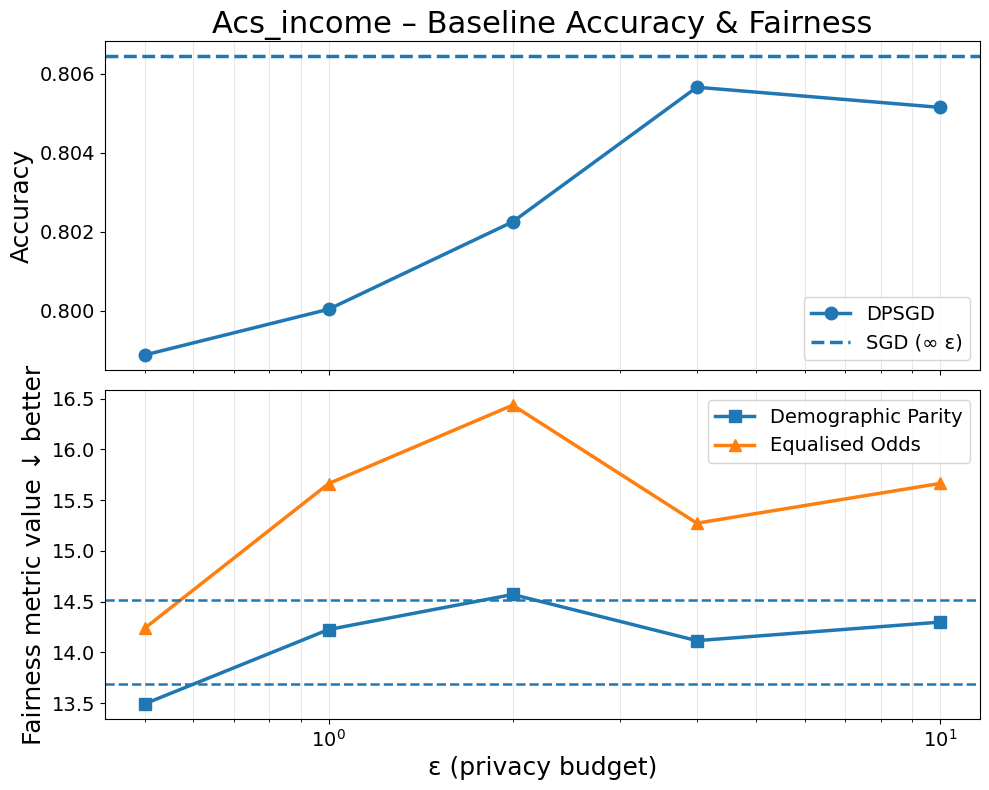

In [ ]:
# --- DATA LOADING ------------------------------------------------------------

# keep only the baseline techniques
BASELINES = df_regular[df_regular["technique"].isin(["sgd", "dpsgd"])]

# --- PLOTTING FUNCTION -------------------------------------------------------
def baseline_plots(df=BASELINES, *, save=False, out_dir=FIGURE_DIR):
    """
    Draws two figures (one per dataset) with:
      • accuracy vs ε (log-x) for SGD + DPSGD
      • fairness metrics (demographic_parity, equalised_odds) vs ε
    Parameters
    ----------
    df : DataFrame
        Must contain columns: technique, accuracy, demographic_parity,
        equalised_odds, and index levels (dataset, epsilon).
    save : bool, default False
        If True, PNG and PDF copies are written to *out_dir*.
    out_dir : str
        Folder for saved figures (created on demand).
    """
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    for dataset, g in df.groupby(level="dataset"):
        # pull out the infinite-ε SGD row once for convenience
        sgd_row = g[g["technique"] == "sgd"].iloc[0]

        # DPSGD rows
        dpsgd = g[g["technique"] == "dpsgd"].reset_index()

        fig, (ax_acc, ax_fair) = plt.subplots(2, 1, sharex=True)

        # ───────── ACCURACY ───────────────────────────────────────────────────
        ax_acc.plot(
            dpsgd["epsilon"], dpsgd["accuracy"],
            marker="o", label="DPSGD"
        )
        ax_acc.axhline(
            sgd_row["accuracy"], linestyle="--", label="SGD (∞ ε)"
        )
        ax_acc.set_xscale("log")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.set_title(f"{dataset.capitalize()} – Baseline Accuracy & Fairness")
        ax_acc.grid(True, which="both", axis="x", alpha=0.3)
        ax_acc.legend()

        # ───────── FAIRNESS METRICS ──────────────────────────────────────────
        for metric, style in [
            ("demographic_parity", "-s"),
            ("equalised_odds",     "-^"),
        ]:
            ax_fair.plot(
                dpsgd["epsilon"], dpsgd[metric],
                style, label=metric.replace("_", " ").title()
            )
            ax_fair.axhline(
                sgd_row[metric], linestyle="--", linewidth=1.8
            )

        ax_fair.set_xscale("log")
        ax_fair.set_xlabel("ε (privacy budget)")
        ax_fair.set_ylabel("Fairness metric value ↓ better")
        ax_fair.grid(True, which="both", axis="x", alpha=0.3)
        ax_fair.legend()

        plt.tight_layout()
        if save:
            for ext in (FIGURE_EXTENSION,):
                fig.savefig(out_dir / f"{dataset}_baseline.{ext}", dpi=300)
        plt.show()

# ----------------------------- DRIVER ----------------------------------------
baseline_plots(save=True)   # set save=True to write files